<a href="https://colab.research.google.com/gist/firmai/571c895fe1ac5180bc249ede54cb1ade/finml-global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center"><h1>Insurance Model</h1></div>

<div style="text-align: center"><b>Anant Singh (as14229)<br>
    <a href="mailto:anant.singh@nyu.edu">anant.singh@nyu.edu</a><br>
    Machine Learning in Financial Engineering</b><br>
</div>

## 1. Overview

### 1.1 Problem Statement

Develop and compare six different machine learning regression models to predict clients’ insurance charges: 

1. Perform an EDA; 
2. Preprocess the data;
3. Build the models;
4. Explain the outputs.

### 1.2. Dataset

There are multiple variables in the dataset:

- **age**: Age of client
- **sex**: Gender of client
- **bmi**: Body Mass Index of client
- **children**: Number of children the client have
- **smoker**: Yes if client is a smoker
- **region**: Geographic region client belongs to
- **charges**: Charges that client pays for Health Insurance
---

## 2. Data Loading

### 2.1. Importing Libraries

In [1]:
import numbers
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
from time import perf_counter as pc
from IPython.display import display
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import mean_squared_log_error,mean_absolute_percentage_error

# Turn off Future Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting Font Scale for plots
sb.set(font_scale=1.1)

# Setting Seaborn Plotting style
sb.set_style("whitegrid")

### 2.2. Loading Dataset

##### Downloading the dataset and loading into pandas DataFrame

In [2]:
dataset = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")

### 2.3. Data Info

##### Getting first five rows of the dataset

In [3]:
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##### Ensure that data is loaded successfully

In [4]:
dataset.shape

(1338, 7)

### 2.4. Data Typecasting

##### Get data types of columns

In [5]:
dataset.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

##### Setting the Data Types
As Pandas is not very good at determining the data types

In [6]:
dataset['sex'] = dataset['sex'].astype('category')
dataset['smoker'] = dataset['smoker'].astype('category')
dataset['children'] = dataset['children'].astype('category')
dataset['region'] = dataset['region'].astype('category')
dataset.dtypes

age            int64
sex         category
bmi          float64
children    category
smoker      category
region      category
charges      float64
dtype: object

---

## 3. Data Analysis

### 3.1. Duplicate Data Removal

Dropping the duplicates rows as duplicate data can bias the models

In [7]:
print('Duplicates Found: ',dataset.duplicated().sum(),'\n\nAfter Removal --\n')
dataset.drop_duplicates(inplace=True)
dataset.info()

Duplicates Found:  1 

After Removal --

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   category
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(4), float64(2), int64(1)
memory usage: 47.6 KB


### 3.2. Univariate Analysis

#### 3.2.1. Numerical Variables

##### Get all the numerical columns for analysis

In [8]:
num_cols = list(dataset.select_dtypes(include=['int64','float64','Int64']))
print(num_cols)

['age', 'bmi', 'charges']


##### Get univariate stats

In [9]:
skewness = [dataset[col].skew() for col in num_cols]
kurtosis = [dataset[col].kurt() for col in num_cols]
stats = dataset.describe()
stats.loc["skew"] = skewness
stats.loc["kurt"] = kurtosis
stats

,age,bmi,charges
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,13279.121487
std,14.044333,6.100468,12110.359656
min,18.000000,15.960000,1121.873900
25%,27.000000,26.290000,4746.344000
50%,39.000000,30.400000,9386.161300
75%,51.000000,34.700000,16657.717450
max,64.000000,53.130000,63770.428010
skew,0.054781,0.283914,1.515391
kurt,-1.244406,-0.052947,1.604221


>**Observations:**
>- `charges` are heavily skewed
>- All the varibales are Platykurtic


##### Plotting Kernel Density over Histogram plots

To get the distribution of numerical varibales

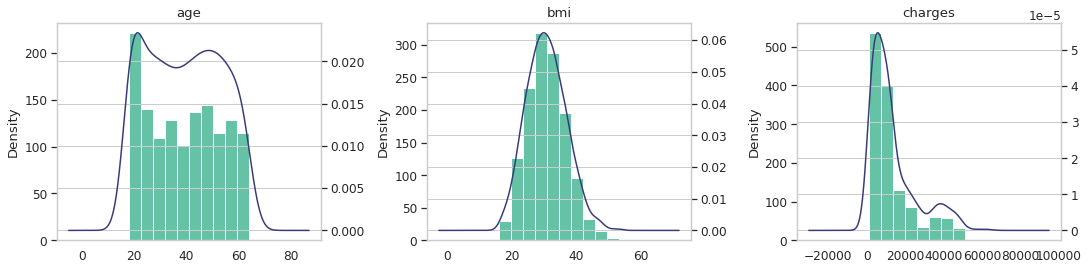

In [10]:
fig, ax = plt.subplots(1,3, figsize=(18, 4)) 
fig.subplots_adjust(wspace=.4)
ax = ax.ravel()

for i, col in enumerate(num_cols):
    ax[i] = dataset[col].plot(kind='hist', sharex=False, ax=ax[i], colormap='Set2')
    ax[i] = dataset[col].plot(kind='density', ax=ax[i], secondary_y=True, colormap='tab20b')
    plt.title(col)

>**Observations**:
>- Data has more youngsters (i.e. 18-20) than any other `age` group
>- As indicated by skewness `charges` is positively skewed

##### Plotting Box and Whisker Plots

To get a sense of outliers

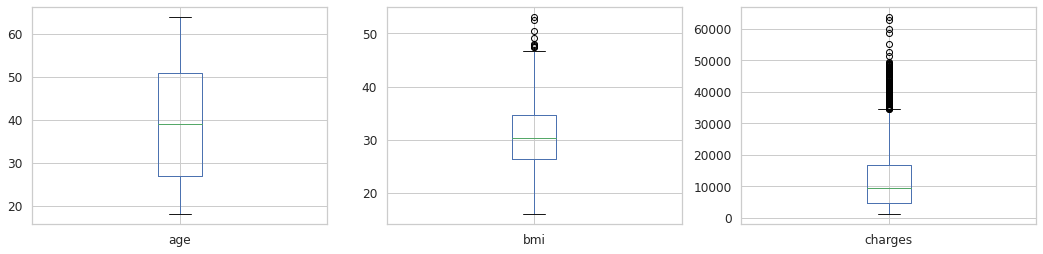

In [11]:
dataset.plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(18, 4));
plt.show()

>**Observations**:
>- Here we can observe that there might be outlier sitution with `bmi` and `charges`

#### 3.2.2. Categorical Variables

##### Get all the categorical columns for analysis

In [12]:
cat_cols = list(dataset.select_dtypes(exclude=['int64','float64','Int64']).columns)
print(cat_cols)

['sex', 'children', 'smoker', 'region']


##### Plotting Count Bar plots

To get the categorical distribution of the dataset

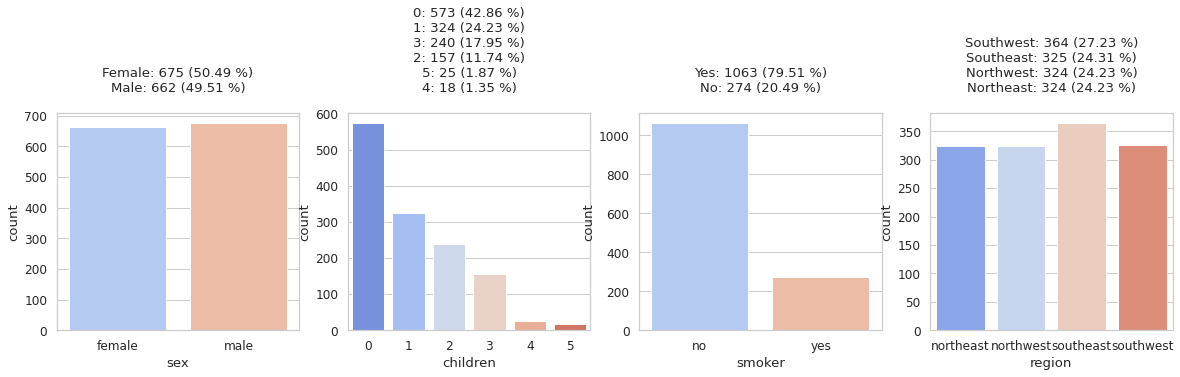

In [13]:
fig, ax = plt.subplots(1,4, figsize=(20, 4)) 
fig.subplots_adjust(wspace=.2)

ax = ax.ravel()

for i, col in enumerate(cat_cols):
    title = ""
    cats = zip(list(dataset[col].unique()),list(dataset[col].value_counts()))
    for cat in cats:
        title += "{}: {} ({:.2f} %)\n"\
            .format(str(cat[0]).title(), cat[1], (cat[1]*100)/dataset.shape[0])
    sb.countplot(x = col, data = dataset, palette ='coolwarm', ax=ax[i]).set(title=title)

>**Observations**:
>- Dataset has almost equal number of males and females
>- Clients with no child are more than any other
>- Dataset has only 20 % clients who smokes
>- Dataset has almost equal number of clients from all the regions

### 3.3. Multivariate Analysis

##### Plotting pairplots

To get a sense of relationships between numerical variables

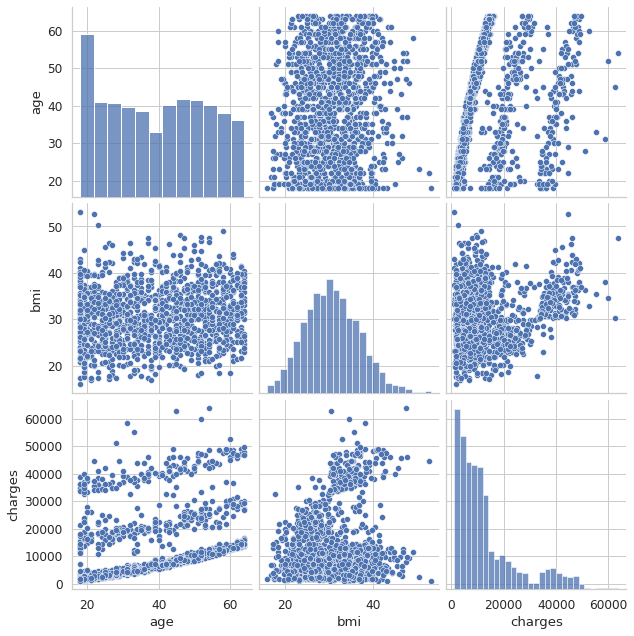

In [14]:
sb.pairplot(dataset, height=3)
plt.show()

>**Observations**:
>- `age` seems to have some kind of three classes for `charges`
>- `bmi` has a strong relationship with `charges` where `bmi` > 30, also there exists some liner relation

##### Plotting Correlation Matrix

To get a sense of co-variability or redundancy

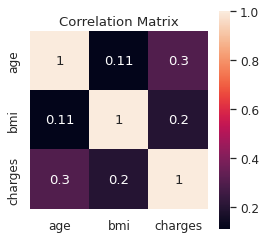

In [15]:
correlation = dataset.corr()
plt.figure(figsize=(4,4))
plt.title('Correlation Matrix')
sb.heatmap(correlation, vmax=1, square=True,annot=True)
plt.show()

>**Observations**:
>- There is no strong correlation exists between the variables

##### Plotting Pairplots with Category : `sex`

To understand the influence of gender on relationships

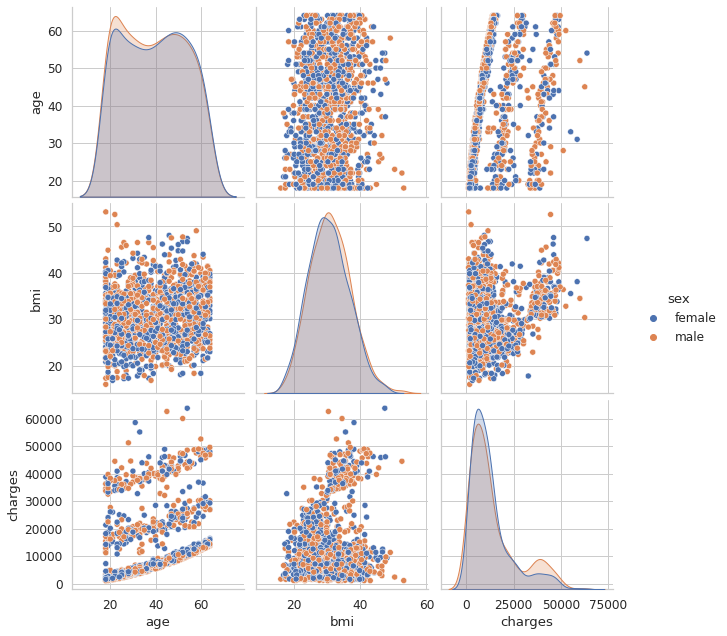

In [16]:
sb.pairplot(dataset, hue='sex', height=3)
plt.show()

>**Observations**:
>- There is no visiable pattern or effect of gender.

##### Plotting Pairplots with Category : `smoker`

To understand the influence of smoking on relationships

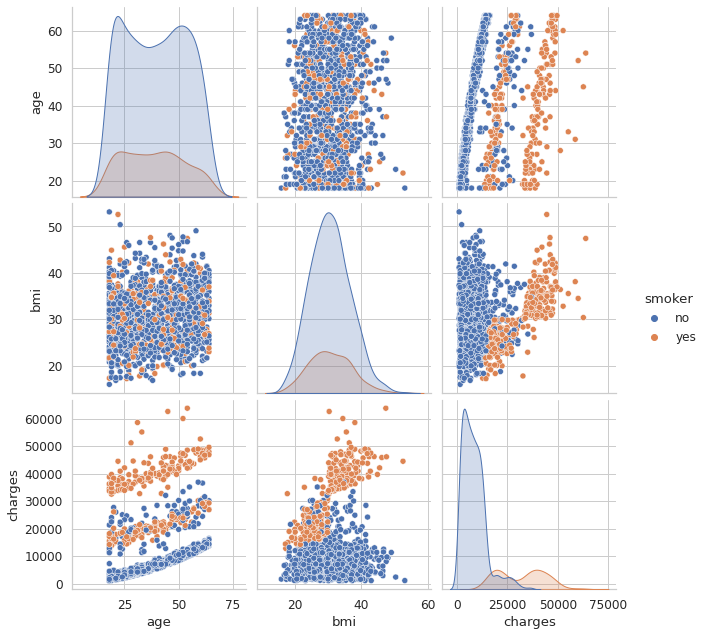

In [17]:
sb.pairplot(dataset, hue='smoker', height=3)
plt.show()

>**Observations**:
>- `smoker` has a strong effect on `charges`
>- Anyone who has a `bmi` over and is a `smoker` is bound to have high `charges`

##### Plotting Pairplots with Category : `region`

To understand the influence of region on relationships

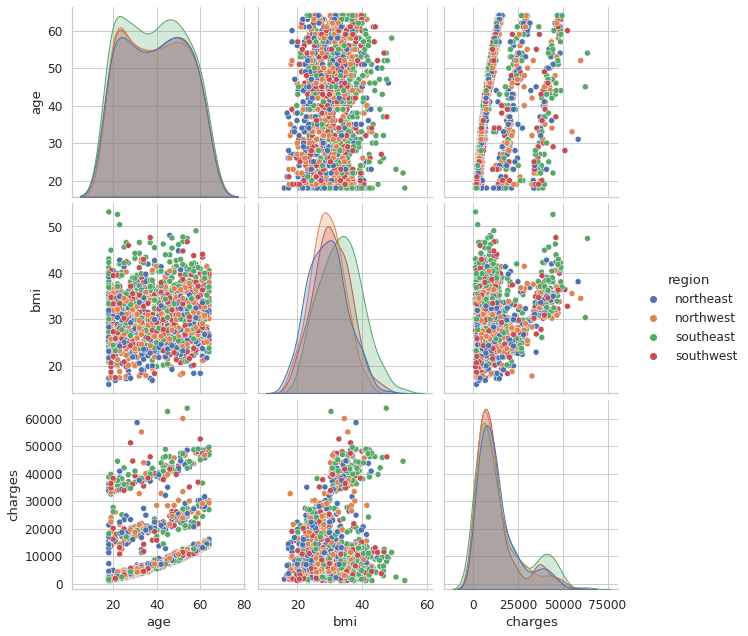

In [18]:
sb.pairplot(dataset, hue='region', height=3)#,palette="husl")
plt.show()

>**Observations**:
>- `region` of client does not have any visible effect
>- Clients from Southwest `region` have slightly high `bmi` distribution
>- Clients from Southwest `region` pays slightly more `charges`

##### Plotting Pairplots with Category : `children`

To understand the influence of number of children on relationships

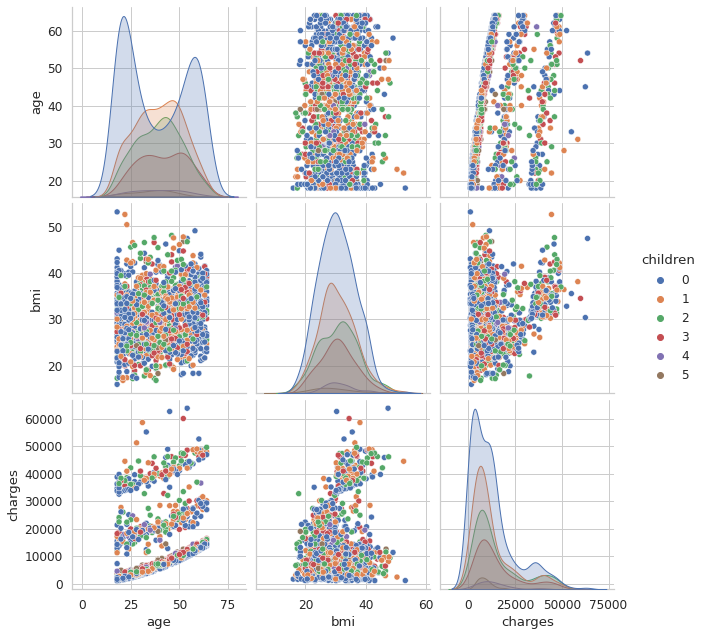

In [19]:
sb.pairplot(dataset, hue='children', height=3)
plt.show()

>**Observations**:
>- Number of `children` does not have any significant effect
>- Dataset has more clients of `age` group (18-30) and (50-64) with no child

##### Plotting Histogram plots for charges with categories

To understand the influence of categories on `charges`

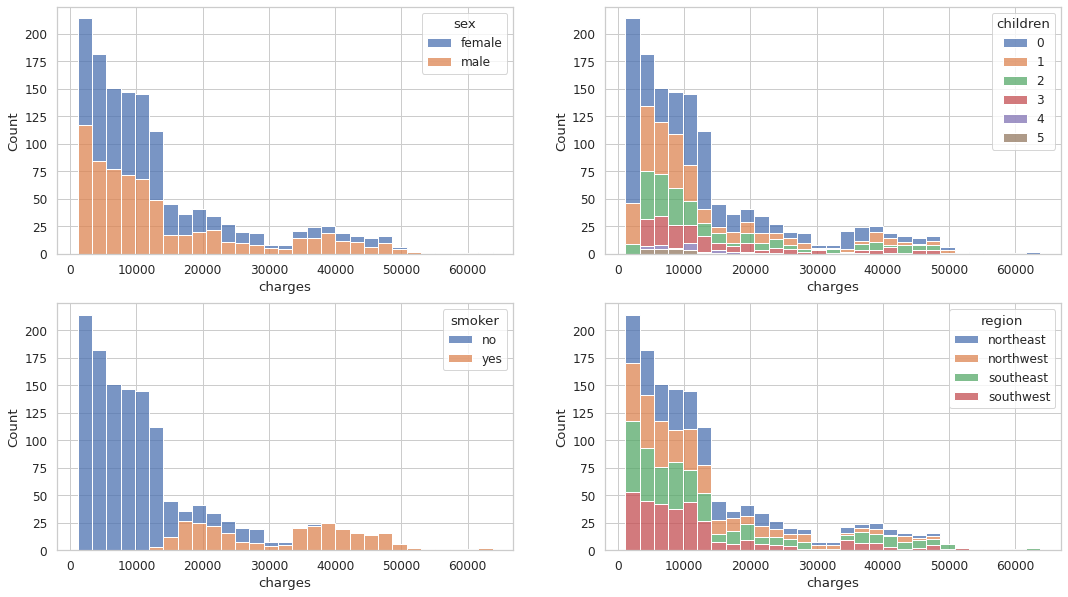

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(18,10))

for col, ax in zip(cat_cols, axs.flatten()):
  sb.histplot(dataset, x='charges', hue=col, multiple='stack', ax=ax)

>**Observations**:
>- `sex` has no effect on `charges`, both `sex` pays similar `charges`
>- There are more people with 0 `children` who pays very low `charges`
>- If client has more than 2 `children` `charges` are bound to increase
>- Clients who is a `smoker` pays more `charges`
>- No significant effect of `region` on `charges`

##### Plotting Cross-Category Histogram Plots

To observe cross-category distribution

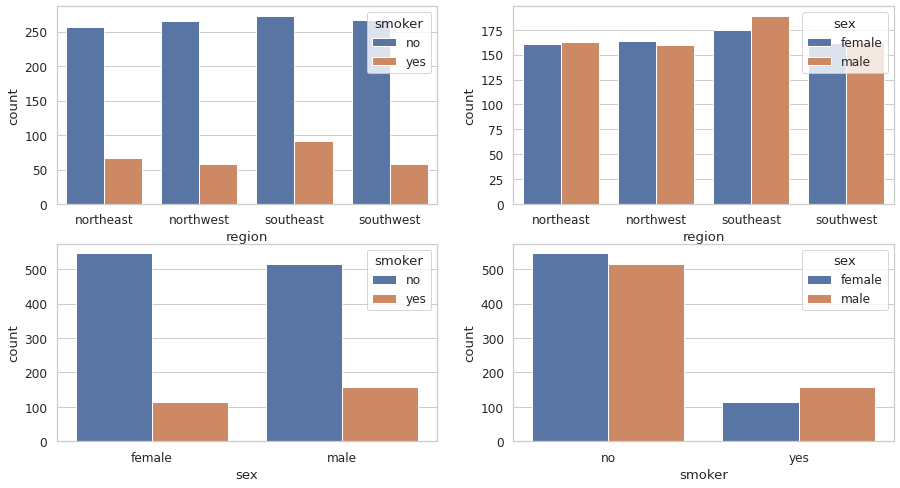

In [21]:
fig, ax = plt.subplots(2,2, figsize=(15, 8)) 
ax = ax.ravel()

sb.countplot(x="region", data=dataset, hue="smoker", ax=ax[0]);
sb.countplot(x="region", data=dataset, hue="sex", ax=ax[1]);
sb.countplot(x="sex", data=dataset, hue="smoker", ax=ax[2]);
sb.countplot(x="smoker", data=dataset, hue="sex", ax=ax[3]);
plt.show()

>**Observations**:
>- Almost equal distribution of `smokers` and non-smokers in all `regions`, except in southeast region which has slightly more number of `smokers`
>- All `regions` have almost equal distribution of males and females, except in southeast region which has slightly more number of males
>- There are more male clients who smokes
>- There are more Male clients who smokes than female clients

##### Plotting Violin Cross-Category Plots

To observe cross-category distribution with `charges`

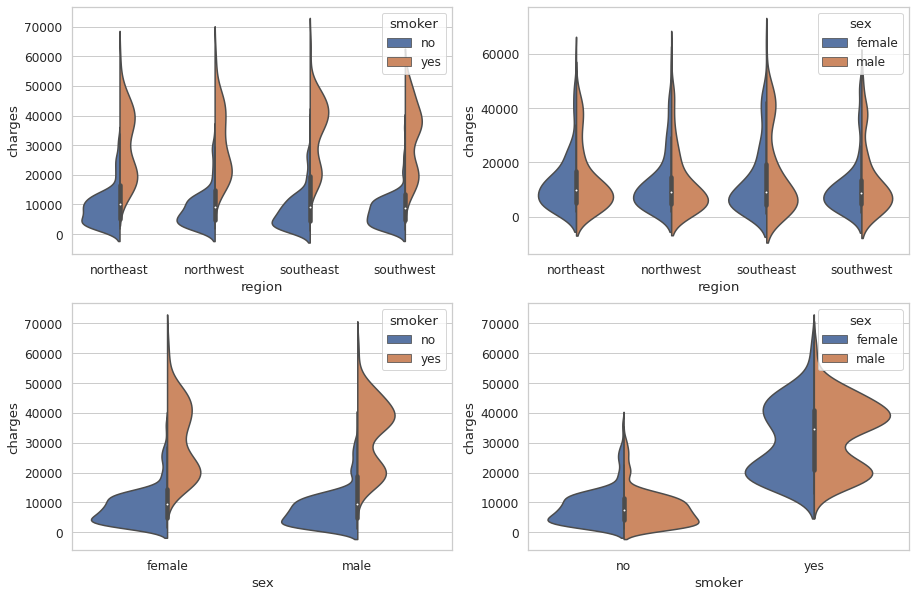

In [22]:
fig, ax = plt.subplots(2,2, figsize=(15, 10)) 
fig.subplots_adjust(wspace=.2)
ax = ax.ravel()

sb.violinplot(x="region", y="charges", data=dataset, hue="smoker", split = True, ax=ax[0])
sb.violinplot(x="region", y="charges", data=dataset, hue="sex", split = True, ax=ax[1])
sb.violinplot(x="sex", y="charges", data=dataset, hue="smoker", split = True, ax=ax[2])
sb.violinplot(x="smoker", y="charges", data=dataset, hue="sex", split = True, ax=ax[3])

plt.show()

>**Observations**:
>- No difference in distribution of clients who do not smokes based on gender
>- Data has more Males clients who smokes more and pays more

### 3.4. Missing Values

##### Get number of Null Entries

In [23]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

> No Missing Entries found
---

## 4. Data Augmentation

##### Add obese categorical column

As found in data analysis obesity influences the charges in a big way, and that migh help our models to predict better

In [24]:
dataset_ex = pd.DataFrame(data=dataset)
dataset_ex['obese'] = dataset_ex['bmi'].apply(lambda bmi: 0 if bmi < 30  else 1)
dataset_ex['obese'] = dataset['obese'].astype('category')
cat_cols = list(dataset.select_dtypes(exclude=['int64','float64','Int64']).columns)
dataset_ex.head()

,age,sex,bmi,children,smoker,region,charges,obese
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


---

## 5. Preprocessing 

### 5.1. Data Seperation

##### Seperate Target and Features

In [25]:
target = ['charges']
features = list(set(dataset_ex.columns) - set(target))
Y = dataset_ex[target]
Y = Y.values.ravel()
X_raw = dataset_ex.drop(target, axis=1)
X_raw.head()

,age,sex,bmi,children,smoker,region,obese
0,19,female,27.900,0,yes,southwest,0
1,18,male,33.770,1,no,southeast,1
2,28,male,33.000,3,no,southeast,1
3,33,male,22.705,0,no,northwest,0
4,32,male,28.880,0,no,northwest,0


### 5.2. Label Encoding

##### Encode categorical columns 

One Hot encode the `region` column and binary encode `sex` and `smoker` column so that models can process them

In [26]:
label_encoder = LabelEncoder()
X_enc = pd.get_dummies(X_raw, columns=["region"])
X_enc["sex"] = label_encoder.fit_transform(X_enc["sex"])
X_enc["smoker"] = label_encoder.fit_transform(X_enc["smoker"])
X_enc.head()

,age,sex,bmi,children,smoker,obese,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0,0,0,0,1
1,18,1,33.770,1,0,1,0,0,1,0
2,28,1,33.000,3,0,1,0,0,1,0
3,33,1,22.705,0,0,0,0,1,0,0
4,32,1,28.880,0,0,0,0,1,0,0


### 5.3. Data Type Optimization

Data Type conversion to optimize the memory usage. Also some models only support basic datatypes.

##### Get Data Types of all columns

In [27]:
X_enc.dtypes

age                    int64
sex                    int64
bmi                  float64
children            category
smoker                 int64
obese               category
region_northeast       uint8
region_northwest       uint8
region_southeast       uint8
region_southwest       uint8
dtype: object

##### Change Data Types

Boolean for categorical columns and 8-bit unsigned int for `children` column

In [28]:
X_enc['sex'] = X_enc['sex'].astype('bool')
X_enc['children'] = X_enc['children'].astype(np.dtype('u1'))
X_enc['smoker'] = X_enc['smoker'].astype('bool')
X_enc['obese'] = X_enc['obese'].astype('bool')
X_enc['region_northeast'] = X_enc['region_northeast'].astype('bool')
X_enc['region_northwest'] = X_enc['region_northwest'].astype('bool')
X_enc['region_southeast'] = X_enc['region_southeast'].astype('bool')
X_enc['region_southwest'] = X_enc['region_southwest'].astype('bool')

X_enc.dtypes

age                   int64
sex                    bool
bmi                 float64
children              uint8
smoker                 bool
obese                  bool
region_northeast       bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object

### 5.4. Test Train Split

Split Testing and training data with testing size set to 30%

In [29]:
np.random.seed(43)
X_train, X_test, Y_train, Y_test = train_test_split(X_enc, Y, test_size = 0.3)
X_train.head()

,age,sex,bmi,children,smoker,obese,region_northeast,region_northwest,region_southeast,region_southwest
1306,29,False,21.85,0,True,False,True,False,False,False
718,51,False,36.67,2,False,True,False,True,False,False
47,28,False,34.77,0,False,True,False,True,False,False
891,36,False,29.04,4,False,False,False,False,True,False
779,53,True,28.88,0,False,False,False,True,False,False


### 5.5. Normalization

Scale the data from range 0 to 1

In [30]:
scaler = MinMaxScaler()
trans_cols = list(set(num_cols)-set(target)) + ["children"]
X_train[trans_cols] = scaler.fit_transform(X_train[trans_cols])
X_test[trans_cols] = scaler.transform(X_test[trans_cols])

X_train.head()

,age,sex,bmi,children,smoker,obese,region_northeast,region_northwest,region_southeast,region_southwest
1306,0.239130,False,0.160841,0.0,True,False,True,False,False,False
718,0.717391,False,0.565538,0.4,False,True,False,True,False,False
47,0.217391,False,0.513654,0.0,False,True,False,True,False,False
891,0.391304,False,0.357182,0.8,False,False,False,False,True,False
779,0.760870,True,0.352813,0.0,False,False,False,True,False,False


---

## 6. Model Development

Six model to be developed are:

- **Elastic Net**
- **Decision Tree Regressor**
- **Random Forest Regressor**
- **AdaBoost Regressor**
- **Gradient Boosting Regressor**
- **XGBoost Regressor**

### 6.1 Helper Functions

##### Helper Function to plot Error Plots for Grid Search

In [31]:
def GSCVplot(grid, model=None, ylim=None, xlim=None):
    '''The Function plots Train and Cross Validation error for all the Parameters keeping
    others at best setting for a given grid search grid.
    '''

    # Get Grid Search Results
    results = pd.DataFrame(grid.cv_results_)
    
    # Get Scores
    meanTrainScore = results['mean_train_score']
    meanValidScore = results['mean_test_score']
    stdTrainScores = results['std_train_score']
    stdValidScores = results['std_test_score']

    # Get parameter columns
    cols = [col for col in results.columns if col[:6] == 'param_']

    # Get range of parameters
    ranges = [grid.param_grid[p[6:]] for p in cols]

    # Get length of ranges of parameters
    rangesLen = [len(pr) for pr in ranges]
    
    # Set - Do not plot if there are no Parameters
    if len(cols):
        
        meanTrainScore = np.array(meanTrainScore).reshape(rangesLen)
        meanValidScore = np.array(meanValidScore).reshape(rangesLen)
        stdTrainScores = np.array(stdTrainScores).reshape(rangesLen)
        stdValidScores = np.array(stdValidScores).reshape(rangesLen)

        paramsToPlot = [param for param, len in zip(grid.best_params_.keys(),rangesLen) if len > 1]

        if len(paramsToPlot):
            # TODO
            '''
            prams[l[i:i+n] for i in range(0, len(l), n)]
            paramTPLen = len(paramsToPlot)
            if paramTPLen > 3:
                plotModulus = paramTPLen % 3
                if plotModulus==0:
                    rowSub = plotModulus
                else:
                    rowSub = int(plotModulus + 1)
                colSub = 3
            else:
                rowSub = 1
                colSub = paramTPLen
            '''
            
            rowSub = 1
            colSub = len(paramsToPlot)
            plt.clf()
            fig ,ax = plt.subplots(rowSub, colSub ,figsize=(6*colSub,4))
            fig.suptitle(model, fontsize=16)

            if colSub>1:
                ax = ax.ravel()
        
        for i, mainParam in enumerate(paramsToPlot):
            mainParam_idx = cols.index('param_' + mainParam)
            slices = []
            for j, p in enumerate(grid.best_params_):
                if (j == mainParam_idx):
                    slices.append(slice(None))
                    continue
                bestParamVal = grid.best_params_[p]
                bestParamIdx = list(ranges[j]).index(bestParamVal)
                slices.append(bestParamIdx)
            
            meanTS = meanTrainScore[tuple(slices)]
            meanVS = meanValidScore[tuple(slices)]
            stdTS = stdTrainScores[tuple(slices)]
            stdVS = stdValidScores[tuple(slices)]

            if colSub > 1: ax[i].set_title('')
            if ylim: plt.ylim(ylim)
            if xlim: plt.xlim(xlim)

            plt.subplot(rowSub,colSub,i+1)
            plt.xlabel(mainParam)
            plt.ylabel('Score')
            plotFunc = plt.plot
            
            if isinstance(ranges[mainParam_idx][0], numbers.Number): 
                range = ranges[mainParam_idx]
            else: range = [str(x) for x in ranges[mainParam_idx]]
                
            plotFunc(range, meanTS, label='Training', color='r', lw=2)
            plt.fill_between(range, meanTS - stdTS, meanTS + stdTS, alpha=0.1, color='r', lw=2)

            plotFunc(range, meanVS, label='Cross-Validation', color='b', lw=2)
            plt.fill_between(range, meanVS - stdVS, meanVS + stdVS, alpha=0.1, color='b', lw=2)
            
            plt.legend(loc='lower right')
            plt.xticks(range)

        plt.show()

##### Helper Function to run Grid Search

In [32]:
def GridSearch(name, regressor, params, scorer, cv=5):
    '''This function runs gridsearch and plots the comparision Train and CV Error plots
    '''
    start = pc()
    grid_obj = GridSearchCV(regressor, params, scoring=scorer, cv=cv, return_train_score=True)

    grid = grid_obj.fit(X_train, Y_train)

    best_reg = grid.best_estimator_
    best_reg.fit(X_train, Y_train)

    test_preds = best_reg.predict(X_test)

    results = [np.round(mean_absolute_error(Y_test,test_preds),3),
               np.round(mean_squared_error(Y_test,test_preds),3),
               np.round(mean_squared_error(Y_test,test_preds,squared=True),3),
#                np.round(mean_squared_log_error(Y_test,test_preds,squared=True),3),
               np.round(mean_absolute_percentage_error(Y_test,test_preds),3),
               np.round(r2_score(Y_test,test_preds),3)
              ]
    
    end = pc()
    if (len(params.keys())):
#         print('\n'+name)
        print("Time Taken:",end-start,'seconds\n')
        bestParams = pd.DataFrame(columns=grid.best_params_.keys())
        bestParams.loc["Best Params"] = grid.best_params_.values()        
        GSCVplot(grid, name)
        display(bestParams)
        

    return results, grid

### 6.2 Baseline Model Comparison

##### Train and get performance metrics

In [33]:
scorer = 'neg_mean_absolute_error'
regressors = {'Elastic Net' : ElasticNet(),
              'Decision Tree' : DecisionTreeRegressor(),
              'Random Forest' : RandomForestRegressor(),
              'AdaBoost' : AdaBoostRegressor(),
              'Gradient Boosting' : GradientBoostingRegressor(),
              'XGBoost' : XGBRegressor()
            }
paramGrid = [{},{},{},{},{},{}]

perf_cols = ['MAE','MSE','RMSE','MAPE','R2-score']
models=[None]*6
modelPerformance = pd.DataFrame(columns=perf_cols)

for i, (name, regressor) in enumerate(regressors.items()):
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid[i], scorer, 10)
display(modelPerformance.sort_values('R2-score',ascending=False).style.background_gradient(cmap='Greens',subset=['R2-score']))
display(modelPerformance.sort_values('MAE').style.background_gradient(cmap='Reds',subset=['MAE']))

,MAE,MSE,RMSE,MAPE,R2-score
Gradient Boosting,2566.998000,21399599.107000,21399599.107000,0.293000,0.861000
Random Forest,2836.127000,25139372.294000,25139372.294000,0.324000,0.837000
AdaBoost,3943.775000,25691932.780000,25691932.780000,0.691000,0.833000
XGBoost,3185.437000,29105451.956000,29105451.956000,0.376000,0.811000
Decision Tree,3418.375000,46335779.908000,46335779.908000,0.429000,0.700000
Elastic Net,7445.365000,105158886.259000,105158886.259000,1.290000,0.318000


,MAE,MSE,RMSE,MAPE,R2-score
Gradient Boosting,2566.998000,21399599.107000,21399599.107000,0.293000,0.861000
Random Forest,2836.127000,25139372.294000,25139372.294000,0.324000,0.837000
XGBoost,3185.437000,29105451.956000,29105451.956000,0.376000,0.811000
Decision Tree,3418.375000,46335779.908000,46335779.908000,0.429000,0.700000
AdaBoost,3943.775000,25691932.780000,25691932.780000,0.691000,0.833000
Elastic Net,7445.365000,105158886.259000,105158886.259000,1.290000,0.318000


>**Observation**:
>- **Gradient Boosting Regressor** has performanced the best

### 6.3 Hyperparameter Optimization

#### 6.3.1 ElasticNet

ElasticNet is a regularised version of simple Linear Regression, it applies L1 and L2 regularization.

It has high explainability which makes it worthy of consideration.

Advantages:
- Explainable
- Fast to train
- Regularized

Disadvantages: 
- The relation between target and independent variable should be linear
- Sensitive to outliers
- It assumes that data is absolutely non-colinear

Time Taken: 2.884157826192677 seconds



<Figure size 432x288 with 0 Axes>

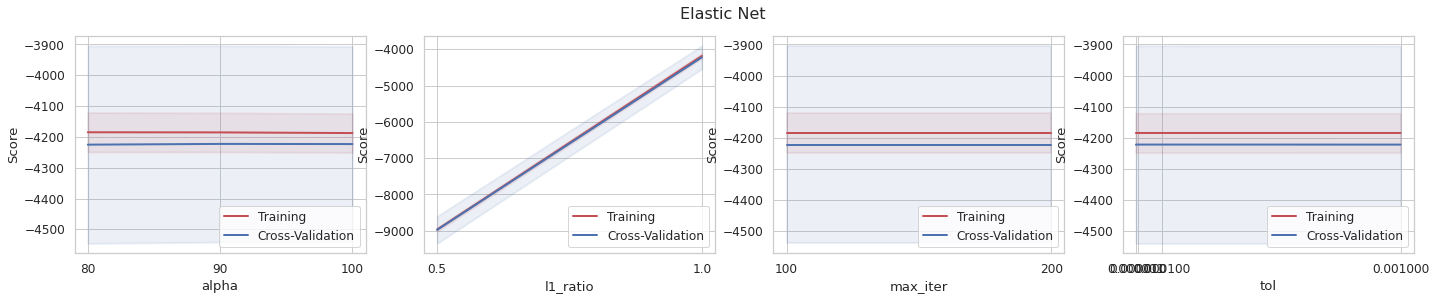

,alpha,l1_ratio,max_iter,random_state,tol
Best Params,90.0,1.0,100.0,43.0,0.000001


,MAE,MSE,RMSE,MAPE,R2-score
Elastic Net,4076.861,3.473810e+07,3.473810e+07,0.418,0.775


In [34]:
regressor = {'Elastic Net':ElasticNet()}
paramGrid = {'alpha':[80,90,100],
              'l1_ratio':[0.5,1],
              'max_iter':[100,200],
              'tol':[1e-3,1e-4,1e-5,1e-6],
              'random_state':[43]
            }
for name, regressor in regressor.items():
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid, scorer, 10)
    models[0]=grid.best_estimator_
    mp=pd.DataFrame(columns=perf_cols)
    mp.loc[name]=modelPerformance.loc[name]
    display(mp)

> ElasticNet doesn't performed well because target and all independent variables doesn't seem to have linear relationship 

#### 6.3.2 Decision Tree Regressor

Decision Tree Regressor is based on tree structure and is very powerful model.

A Lot of other ensemble models are based on decision tree and hence it is considered to compared to other more complex ensemble model.

Advantages:
- Generate understandable rules
- It can handle Categorical as well as numerical variables
- They provide clear feature importance

Disadvantages:
- Less appropriate for continuous target estimation
- Be be computationally expensive
- Prone to overfitting
- Can't extrapolate

Time Taken: 53.55135369580239 seconds



<Figure size 432x288 with 0 Axes>

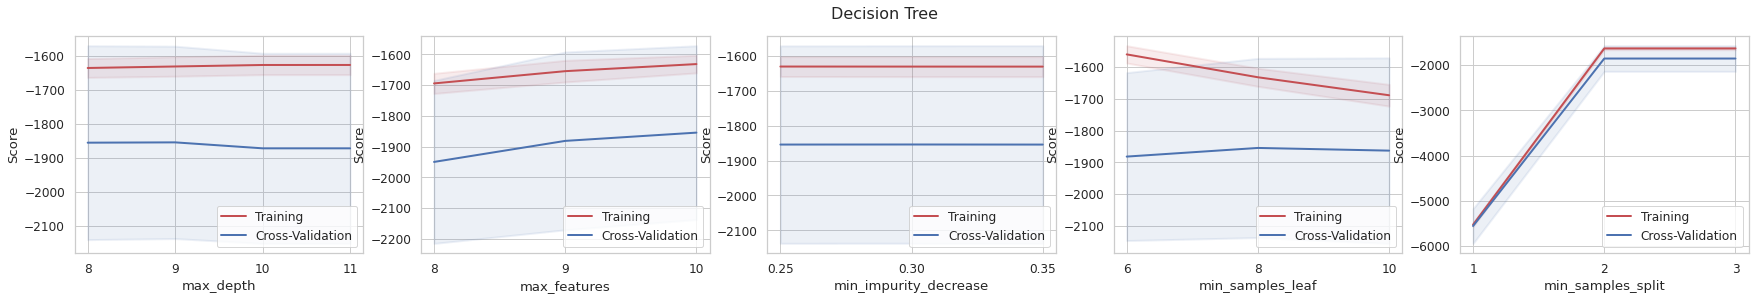

,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state
Best Params,absolute_error,9,10,0.3,8,2,43


,MAE,MSE,RMSE,MAPE,R2-score
Decision Tree,1903.367,20962263.37,20962263.37,0.128,0.864


In [35]:
regressor = {'Decision Tree' : DecisionTreeRegressor()}
paramGrid = {
            'criterion':['absolute_error'],
            'max_depth':[8,9,10,11],
            'max_features':[8,9,10],
            'min_impurity_decrease':[0.25,0.3,0.35], 
            'min_samples_leaf':[6,8,10],
            'min_samples_split':[1.0,2,3],
            'random_state':[43]
            }
for name, regressor in regressor.items():
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid, scorer, 10)
    models[1]=grid.best_estimator_
    mp=pd.DataFrame(columns=perf_cols)
    mp.loc[name]=modelPerformance.loc[name]
    display(mp)

> Decision Tree Performs relatively well beacuse it can handle categorical variables very well and generalize well.

#### 6.3.3 Random Forest Regressor

Random Forest is an ensemble model and based on Decision Trees, it is basically an ensemble of weak Decision Trees.

It will perform better than Decision Tree for sure and that makes it worthy to be considered.

Advantages:
- Handles overfitting well
- No feature scaling required
- Robust to outliers
- Can handle regression and classification problems

Disadvantages:
- Can't extrapolate
- Very complex
- Time consuming training

Time Taken: 291.05235446989536 seconds



<Figure size 432x288 with 0 Axes>

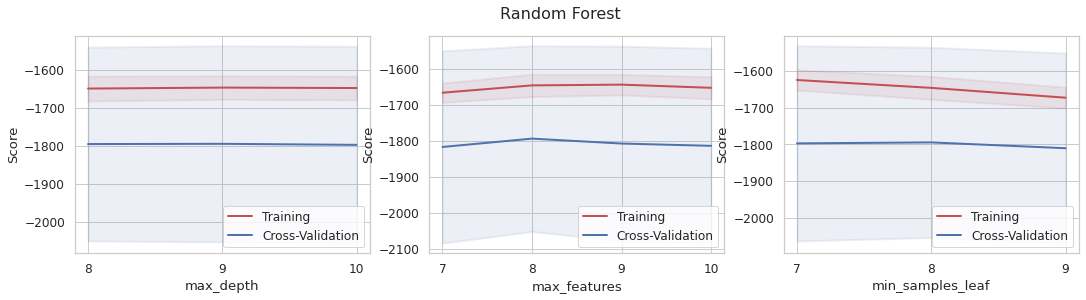

,criterion,max_depth,max_features,min_samples_leaf,n_estimators,random_state
Best Params,absolute_error,9,8,8,100,43


,MAE,MSE,RMSE,MAPE,R2-score
Random Forest,1751.743,2.017605e+07,2.017605e+07,0.125,0.869


In [36]:
regressor = {'Random Forest' : RandomForestRegressor()}
paramGrid = {
            'criterion':['absolute_error'],
            'n_estimators':[100],
            'max_depth':[8,9,10], 
            'max_features':[7,8,9,10],
            'min_samples_leaf':[7,8,9],
            'random_state':[43]
            }
for name, regressor in regressor.items():
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid, scorer, 10)
    models[2]=grid.best_estimator_
    mp=pd.DataFrame(columns=perf_cols)
    mp.loc[name]=modelPerformance.loc[name]
    display(mp)

> Random forest performed well as it can handle overfitting by ensembling and hence better generalization.

#### 6.3.4 AdaBoost Regressor

AdaBoost is an ensemble method that uses trees in series. AdaBoost implements boosting, wherein a set of weak classifiers is connected in series such that each weak classifier tries to improve the classification of samples that were misclassified by the previous weak classifier.

It is considered because it is a different approach to naive Bagging and is more efficient in theory.

Advantages:
- Explainability

Disadvantages:
- Sensitive to noisy data
- slower than XGBoost
- Sensitive to outliers


Time Taken: 14.234322318807244 seconds



<Figure size 432x288 with 0 Axes>

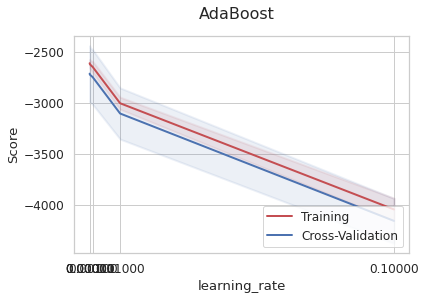

,learning_rate,n_estimators,random_state
Best Params,0.000001,100.0,43.0


,MAE,MSE,RMSE,MAPE,R2-score
AdaBoost,2668.154,2.059222e+07,2.059222e+07,0.37,0.866


In [37]:
regressor = {'AdaBoost' : AdaBoostRegressor()}
paramGrid = {
            'n_estimators':[100],
            'learning_rate':[1e-01,1e-02,1e-03,1e-04,1e-05,1e-06],
            'random_state':[43]
            }
for name, regressor in regressor.items():
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid, scorer, 10)
    models[3]=grid.best_estimator_
    mp=pd.DataFrame(columns=perf_cols)
    mp.loc[name]=modelPerformance.loc[name]
    display(mp)

> Adaboost did not performed as good as Random Forest, this might be due to the design of AdaBoost algorithm, it is sequential.

#### 6.3.5 Gradient Boosting Regressor

Gradient Boosting is an ensemble of decision tress. The algorithm trains learners based upon minimising the loss function of a learner.

It is a different approach to Boosting and has regularization inbuilt hence it is a good consideration.

Advantages:
- It has built in Regularization

Disabvantages:
- Likely to overfit
- Bad at Extrapolarition

Time Taken: 327.49033872410655 seconds



<Figure size 432x288 with 0 Axes>

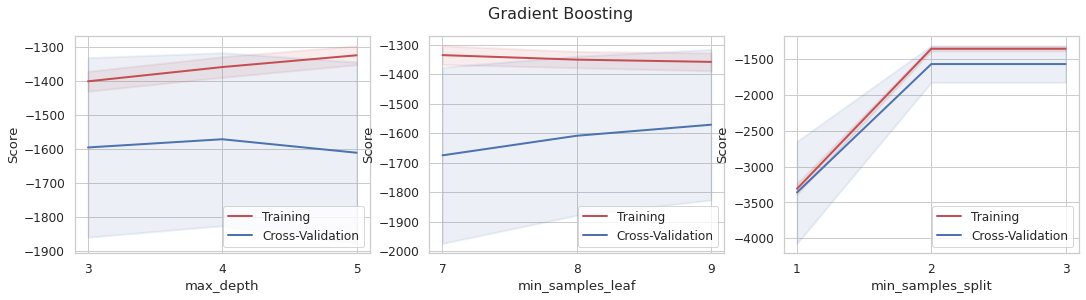

,criterion,learning_rate,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state
Best Params,absolute_error,0.5,4,9,2,100,43


,MAE,MSE,RMSE,MAPE,R2-score
Gradient Boosting,1537.552,2.013512e+07,2.013512e+07,0.086,0.869


In [38]:
regressor = {'Gradient Boosting' : GradientBoostingRegressor()}
paramGrid = {
            'n_estimators':[100],
            'criterion':['absolute_error'],
            'learning_rate':[5e-1], 
            'max_depth':[3,4,5], 
            'min_samples_leaf':[7,8,9], 
            'min_samples_split':[1.0,2,3],
            'random_state':[43]
            }

for name, regressor in regressor.items():
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid, scorer, 10)
    models[4]=grid.best_estimator_
    mp=pd.DataFrame(columns=perf_cols)
    mp.loc[name]=modelPerformance.loc[name]
    display(mp)

> Gradient Boosting Regressor performed really well beacause it has inbuilt regularization.

#### 6.3.6 XGBoost Regressor

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree ensemble model. It provides parallel tree boosting and is the leading machine learning model.

XGBoost is a viable choice as it an improvement over gradient boosting and naive bagging algorithms.


Advantages:
- It has built in Regularization
- It supports parallel processing
- It can run on GPU

Disabvantages:
- Likely to overfit
- Bad at Extrapolarition

Time Taken: 42.368627989664674 seconds



<Figure size 432x288 with 0 Axes>

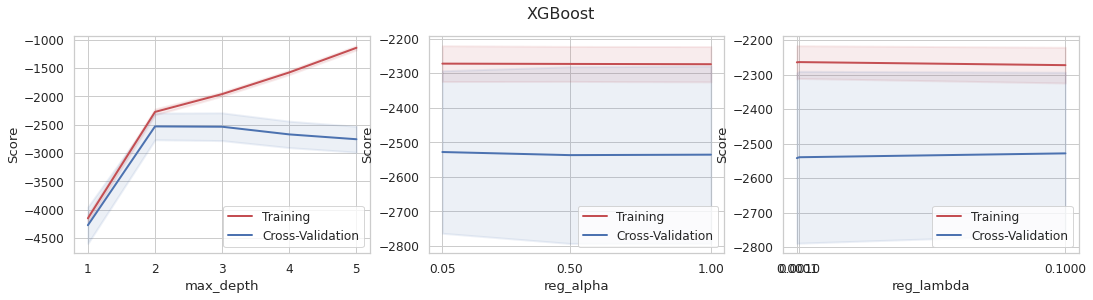

,learning_rate,max_depth,n_estimators,random_state,reg_alpha,reg_lambda,tree_method
Best Params,0.1,2,100,43,0.05,0.1,gpu_hist


,MAE,MSE,RMSE,MAPE,R2-score
XGBoost,2522.038,1.997128e+07,1.997128e+07,0.309,0.871


In [42]:
regressor = {'XGBoost' : XGBRegressor()}
paramGrid = { 
            'learning_rate':[0.1], 
            'max_depth':[1,2,3,4,5],  
            'n_estimators':[100],
            'reg_alpha':[1,5e-1,5e-2],
            'reg_lambda':[1e-1,1e-3,1e-4], 
            'tree_method':['gpu_hist'],
            'random_state':[43], 
}
for name, regressor in regressor.items():
    modelPerformance.loc[name], grid = GridSearch(name, regressor, paramGrid, scorer, 10)
    models[5]=grid.best_estimator_
    mp=pd.DataFrame(columns=perf_cols)
    mp.loc[name]=modelPerformance.loc[name]
    display(mp)

> XGB performed fairly because its an ensemble model and this dataset is very small

### 6.4. Model Selection

##### Model Comparison after Optimization

In [104]:
display(modelPerformance.sort_values('R2-score',ascending=False).style.background_gradient(cmap='Greens',subset=['R2-score']))
display(modelPerformance.sort_values('MAE').style.background_gradient(cmap='Reds',subset=['MAE']))

,MAE,MSE,RMSE,MAPE,R2-score
XGBoost,2522.038000,19971281.031000,19971281.031000,0.309000,0.871000
Random Forest,1751.743000,20176047.308000,20176047.308000,0.125000,0.869000
Gradient Boosting,1537.552000,20135120.356000,20135120.356000,0.086000,0.869000
AdaBoost,2668.154000,20592217.018000,20592217.018000,0.370000,0.866000
Decision Tree,1903.367000,20962263.370000,20962263.370000,0.128000,0.864000
Elastic Net,4076.861000,34738096.906000,34738096.906000,0.418000,0.775000


,MAE,MSE,RMSE,MAPE,R2-score
Gradient Boosting,1537.552000,20135120.356000,20135120.356000,0.086000,0.869000
Random Forest,1751.743000,20176047.308000,20176047.308000,0.125000,0.869000
Decision Tree,1903.367000,20962263.370000,20962263.370000,0.128000,0.864000
XGBoost,2522.038000,19971281.031000,19971281.031000,0.309000,0.871000
AdaBoost,2668.154000,20592217.018000,20592217.018000,0.370000,0.866000
Elastic Net,4076.861000,34738096.906000,34738096.906000,0.418000,0.775000


>**Observation**:
>- **Gradient Boosting Regressor** has performance the best base on Mean Absolute Error

##### Select Best Perfoming Model

In [105]:
model = models[4]
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_mae = np.round(mean_absolute_error(Y_train,train_predictions),3)
train_mse = np.round(mean_squared_error(Y_train,train_predictions),3)
train_r2 = np.round(r2_score(Y_train,train_predictions),3)

test_mae = np.round(mean_absolute_error(Y_test,test_predictions),3)
test_mse = np.round(mean_squared_error(Y_test,test_predictions),3)
test_r2 = np.round(r2_score(Y_test,test_predictions),3)

mp=pd.DataFrame(columns=['Train MAE','Test MAE','Train MSE','Test MSE','Train R2-score','Test R2-score'])
mp.loc["Gradient Boosting"]= [train_mae,test_mae,train_mse,test_mse,train_r2,test_r2]
display(mp)

,Train MAE,Test MAE,Train MSE,Test MSE,Train R2-score,Test R2-score
Gradient Boosting,1368.801,1537.552,1.997313e+07,2.013512e+07,0.861,0.869


---

## 7. Model analysis

### 7.1. Residual Analysis

Plotting the Residuals vs Prdictions plot to observe the error in predictions

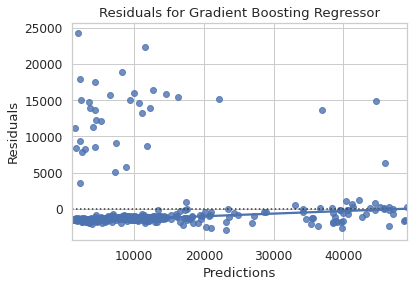

In [106]:
sb.residplot(x=test_predictions, y=Y_test, lowess=True, color="b")
plt.title("Residuals for Gradient Boosting Regressor")
plt.ylabel("Residuals")
plt.xlabel("Predictions")
plt.show();

>**Observation**:
>- Model predicted less than it should have in many cases and that is understandable as it is due to overlapping distributions as observed in the data analysis.

### 7.2. Error Analysis

Plotting charges vs Predicted charges

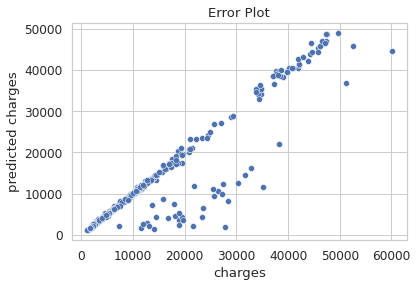

In [109]:
sb.scatterplot(x=Y_test, y=test_predictions);
plt.title('Error Plot')
plt.xlabel("charges")
plt.ylabel("predicted charges")
plt.show()

>**Observation**:
>- The error plot show the same results as observed in Residual Plot

### 7.3. Feature Importance

Plotting Feature Importance as per the model

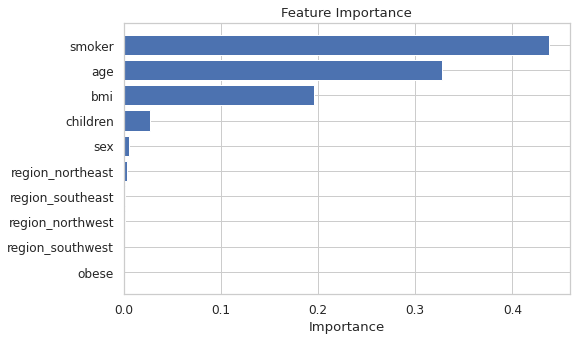

In [110]:
feature_importance = model.feature_importances_
feature_importance = feature_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(8, 5))
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

>**Observation**:
>- The results reflect the observations made during Data Analysis
>- As it can be seen in the plot `smoker` is the most important feature and then `age` and `bmi`
>- `children` is slightly important same as it was observed in Data Analysis
>- `region` is not important at all for the model and it was observed in Data Analysis

---

## Final Assesment

As observed in before and after hyperparameter optimization performance metrics all the models performed better after Hyperparameter Optimization. Gradient Boosting Regreesor remained the best performer. Mean Absolute Error is used because MAE is not as sensitive to outliers as MSE. Error plots showed that GBR performed well on this dataset and it reflected the observations made in Data Analysis step. The region column can be droped as it doesn't explain any variance.